In [1]:
from pathlib import Path

import nibabel as nib
from nilearn.interfaces.bids import get_bids_files, parse_bids_filename
from nilearn.interfaces.fmriprep import load_confounds
from nilearn import datasets
from nilearn.maskers import NiftiMapsMasker, NiftiLabelsMasker
from nilearn.connectome import GroupSparseCovariance
from nilearn import plotting
from sklearn.utils import Bunch

import matplotlib.pyplot as plt
import pandas as pd

from connectivity.atlases import atlas_mapping


# TODO Complete test of rsn41
BIDSDIR = Path("/georges/memento/BIDS")
ATLAS = "difumo"

In [2]:

class Atlas(Bunch):
    @classmethod
    def from_kwargs(cls, name, soft, **atlas_kwargs) -> None:
        new = cls(**atlas_kwargs)

        new.is_soft = soft
        new.name = name
        return new
    
    @classmethod
    def from_name(cls, name, soft):
        atlas_kwargs = atlas_mapping[name]()
        new = cls(**atlas_kwargs)
        new.is_soft = soft
        new.name = name
        new.labels_ = atlas_kwargs["labels"]
        return new

    def get_coords(self):
        if "region_coords" in self.keys():
            return self.region_coords
        elif self.is_soft:
            return plotting.find_probabilistic_atlas_cut_coords(self.maps)
        else:
            return plotting.find_parcellation_cut_coords(self.maps)
    
    def overlay(self):
        raise NotImplementedError()

    def plot(self, **plotting_kwargs):
        if self.is_soft:
            return plotting.plot_prob_atlas(self.maps, title=self.name, **plotting_kwargs)
        else:
            return plotting.plot_roi(self.maps, title=self.name, **plotting_kwargs)

    def fit_masker(self, **masker_kw):
        if self.is_soft:
            masker = NiftiMapsMasker(
                maps_img=self.maps,
                **masker_kw
            )
        else:
            masker = NiftiLabelsMasker(
                labels_img=self.maps
            )
        masker.fit()
        return masker

    @property
    def labels(self):
        # The issue is that for difumo the labels
        # are in a data frame
        # Check type of labels instead?
        if self.name == "difumo":
            return self.labels_.difumo_names.to_list()
        else:
            return self.labels_
            

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/nilearn/plotting/displays/_axes.py:74: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(


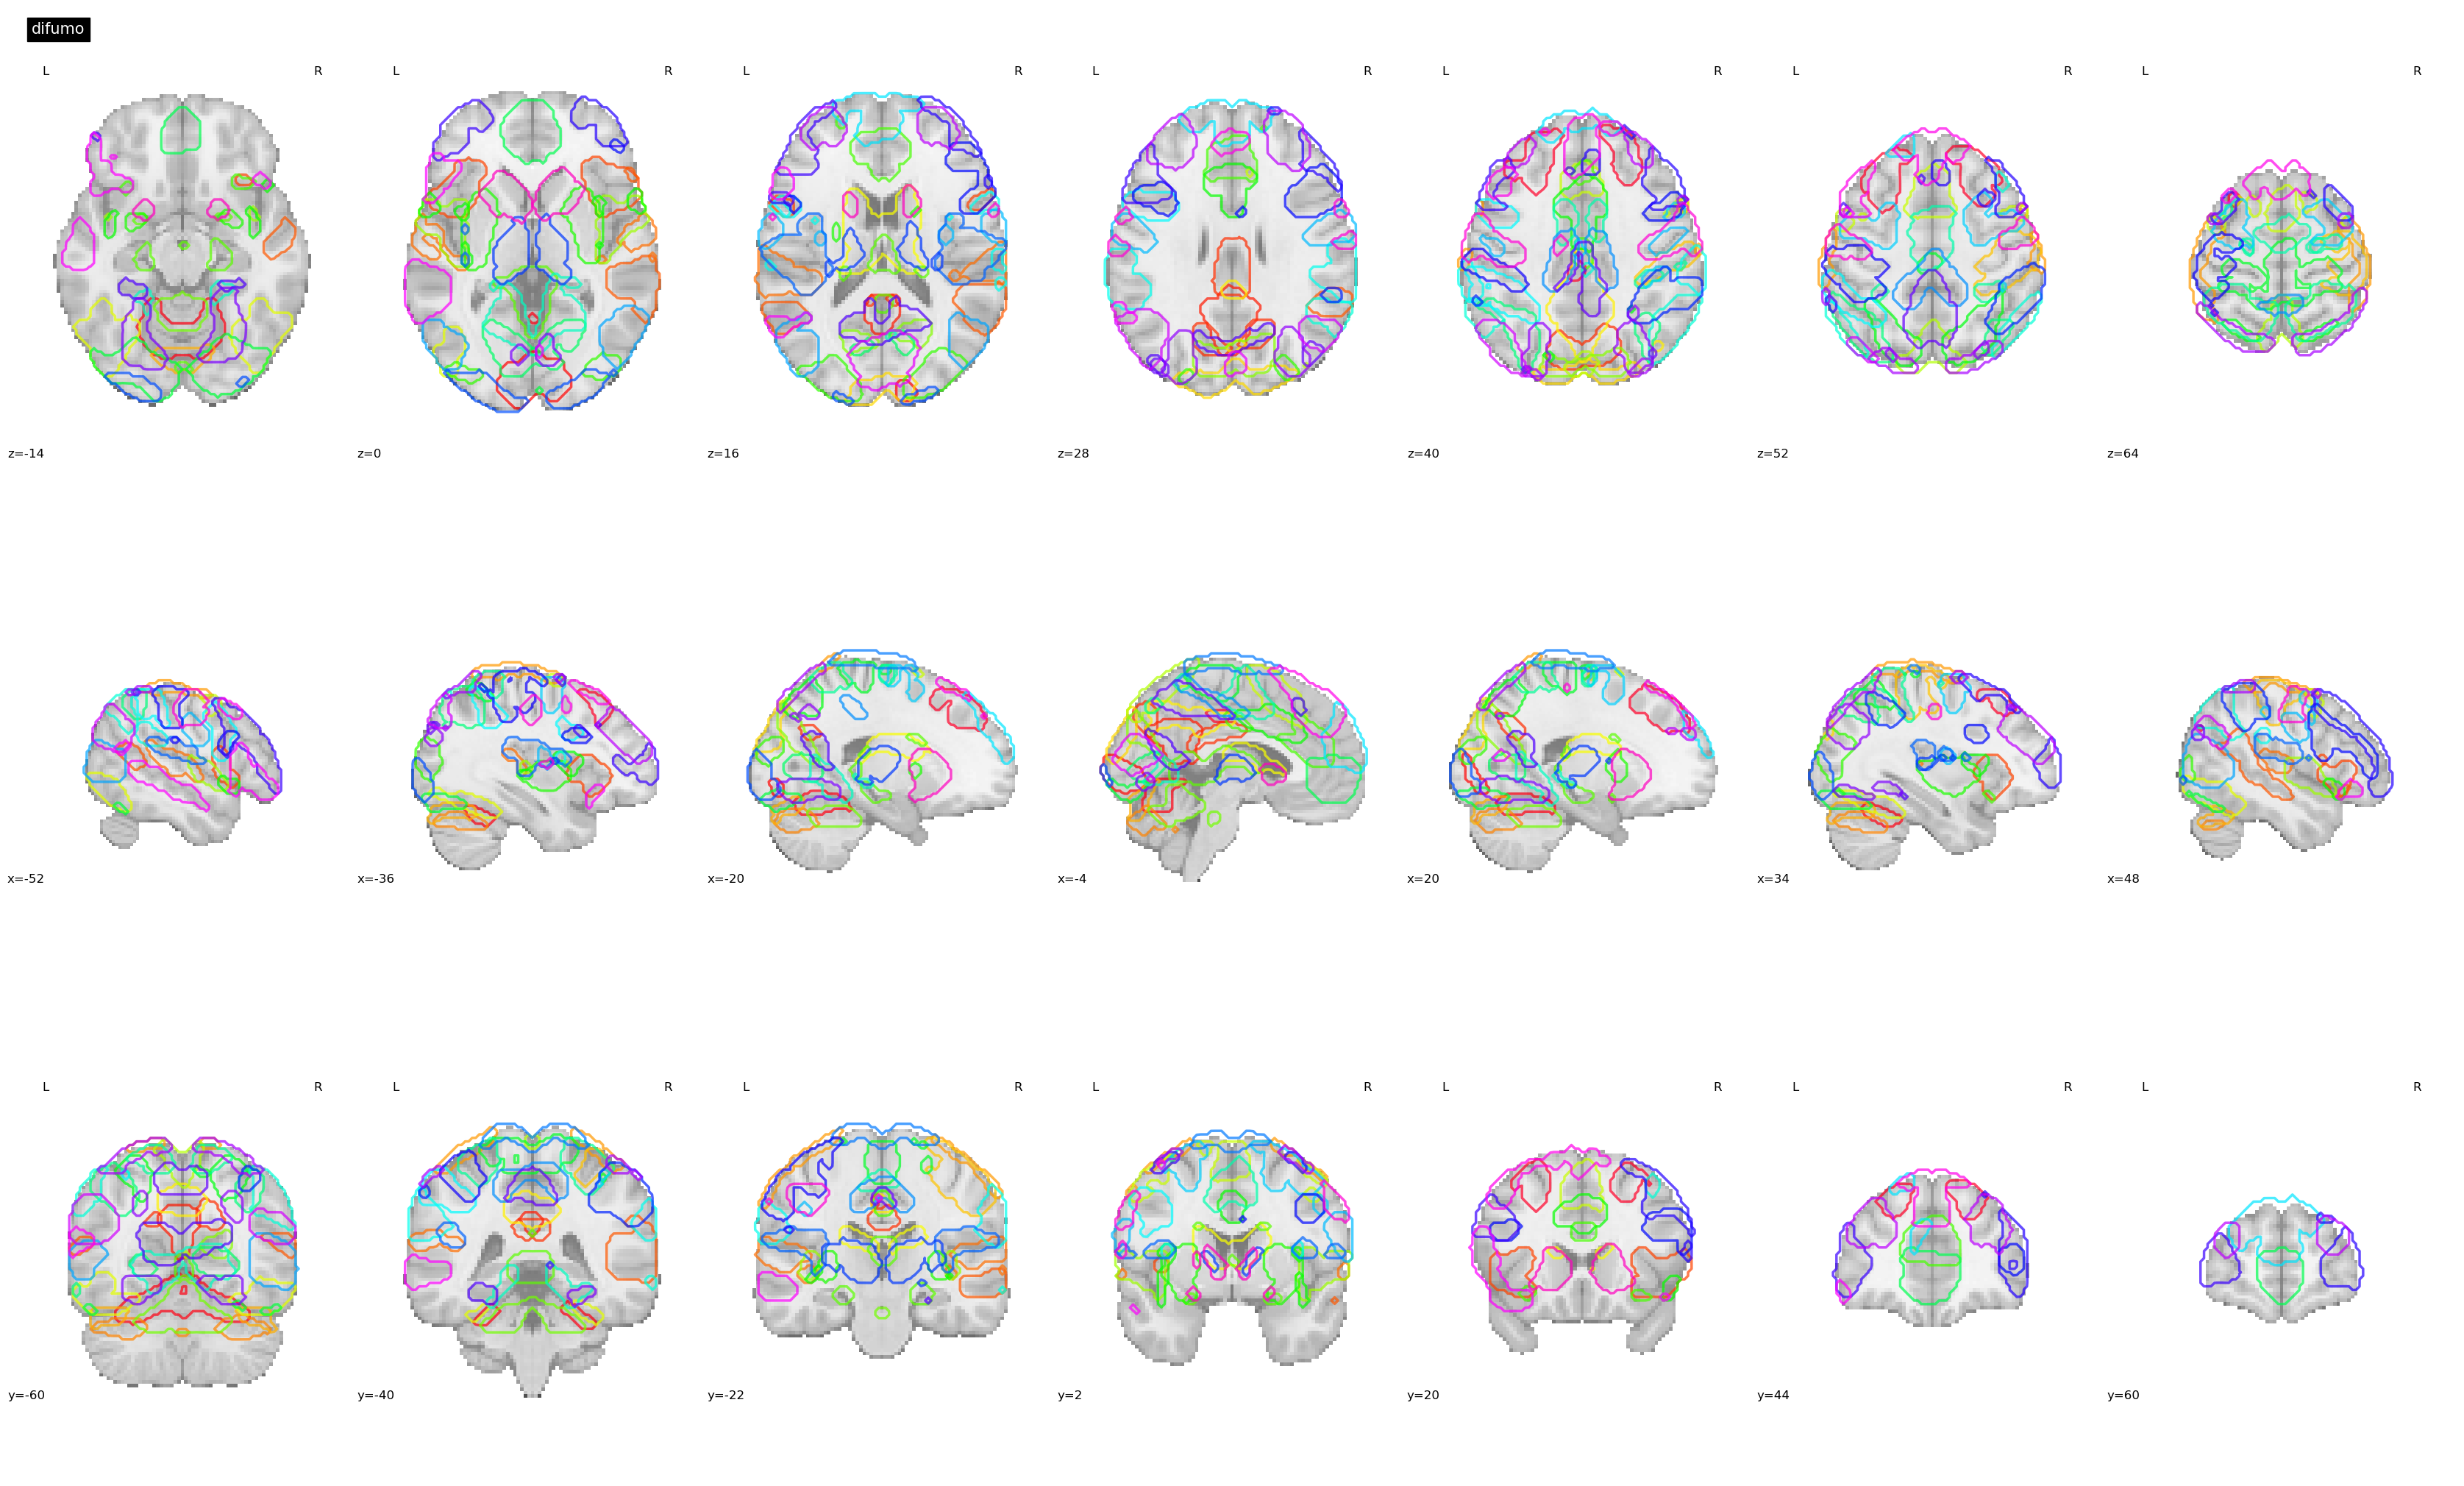

['Superior frontal sulcus', 'Fusiform gyrus', 'Calcarine cortex posterior', 'Cingulate cortex posterior', 'Parieto-occipital sulcus superior', 'Insula antero-superior', 'Superior temporal sulcus with angular gyrus', 'Planum temporale', 'Cerebellum Crus II', 'Superior parts of Postcentral and Precentral gyri', 'Transverse sinus', 'Paracentral gyrus RH', 'Superior occipital gyrus', 'Cingulate gyrus mid-posterior', 'ventricles', 'Fusiform gyrus posterior', 'Superior frontal gyrus medial', 'Precuneus superior', 'Planum polare', 'Parieto-occipital sulcus middle', 'Cerebellum I-V', 'Superior fornix and isthmus', 'Anterior Cingulate Cortex', 'Descending occipital gyrus', 'Putamen', 'Cingulate gyrus mid-anterior', 'Superior parietal lobule posterior', 'Paracentral lobule', 'Inferior occipital gyrus', 'Superior rostral gyrus', 'Calcarine sulcus anterior', 'Intraparietal sulcus', 'Superior parietal lobule anterior', 'Precentral gyrus medial', 'Lingual gyrus anterior', 'Angular gyrus superior', '

In [3]:
atlas = Atlas.from_name(ATLAS, soft=True)
atlas.plot(display_mode="mosaic")
plotting.show()
print(atlas.labels)

In [4]:
fmri_path = get_bids_files(
    BIDSDIR / "derivatives/fmriprep-23.2.0",
    "bold",
    modality_folder="func",
    file_type="nii.gz",
    filters=[
    #    #("space", "MNI152NLin2009cAsym")
        ("space", "MNI152NLin6Asym")
    ],
)

In [5]:
df = pd.DataFrame(map(parse_bids_filename, fmri_path))

ses_count = df.groupby("sub")["ses"].count()

complete_subs = ses_count[ses_count == 3].index.to_list()
complete_df = df[df["sub"].isin(complete_subs)]

In [6]:
from data.memento import Memento

phenotypes = Memento.load_phenotypes("/bigdata/jlegrand/data/Memento/output/augmented_phenotypes.csv", augmented=True)
phenotypes["sub"] = phenotypes["NUM_ID"].map(lambda x: x[4:])
phenotypes["is_demented"] = ~phenotypes.DEMENCE_DAT.isna()

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
rest_dataset = pd.merge(
    left=complete_df,
    right=phenotypes,
    how="left",
    on="sub"
)
if any(rest_dataset["CEN_ANOM"].isna()):
    import warnings
    warnings.warn("Not all subjects have a phenotype, some have been droppped")

    # For now we remove the subjects with no diagnosis
    rest_dataset = rest_dataset.dropna(axis=0, subset="CEN_ANOM")


/tmp/ipykernel_2467801/1011048582.py:9: UserWarning: Not all subjects have a phenotype, some have been droppped
  warnings.warn("Not all subjects have a phenotype, some have been droppped")


In [8]:
masker = atlas.fit_masker()

In [9]:
confound_regression = {
    "strategy": ["high_pass", "motion", "wm_csf"],
    "motion": "basic",
    "wm_csf": "basic"
}
time_series = []
for index, subrow in rest_dataset.sample(n=3).iterrows():
    # Preloading with nib is faster than passing a string path
    # to nilearn
    img = nib.load(subrow.file_path)
    confounds, sample_mask = load_confounds(
        subrow.file_path,
        **confound_regression
    )
    ts = masker.transform(img, confounds, sample_mask)
    time_series.append(ts)


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/joblib/memory.py:349: FutureWarning: The de

In [10]:
from nilearn.connectome import GroupSparseCovarianceCV
from sklearn.covariance import GraphicalLassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(
    StandardScaler(),
    GraphicalLassoCV(n_jobs=8, max_iter=1000),
)
pipe.fit(time_series[1])
estimator = pipe.named_steps["graphicallassocv"]

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.0005250407139712918
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.0005655529817455453
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.0005747286981720703
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/homes_unix/jlegrand/miniconda3

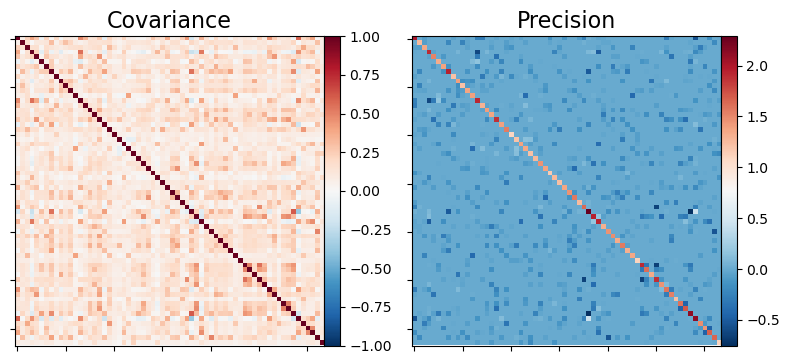

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plotting.plot_matrix(estimator.covariance_, axes=axes[0], vmax=1, vmin=-1, title="Covariance")
plotting.plot_matrix(estimator.precision_, axes=axes[1], title="Precision")
plt.show()

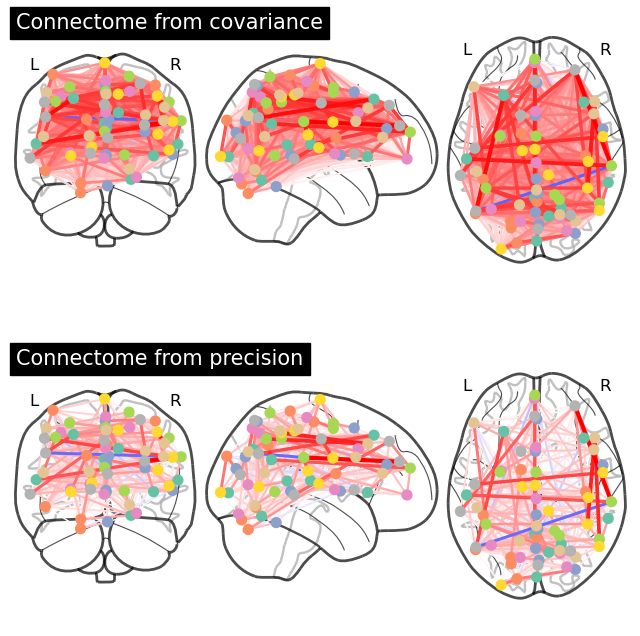

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
plotting.plot_connectome(estimator.covariance_, node_coords=atlas.get_coords(), title="Connectome from covariance", axes=axes[0])
plotting.plot_connectome(-estimator.precision_, node_coords=atlas.get_coords(), title="Connectome from precision", axes=axes[1])
plotting.show()

In [13]:

gsc = GroupSparseCovariance()
sc = StandardScaler() # Could be refactored in a more elegant way but whatever
standardized_ts = [sc.fit_transform(ts) for ts in time_series]
gsc.fit(standardized_ts)


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/nilearn/connectome/group_sparse_cov.py:496: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(


GroupSparseCovariance()

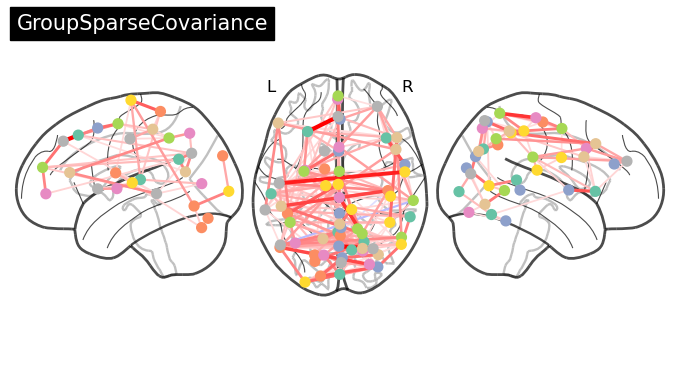

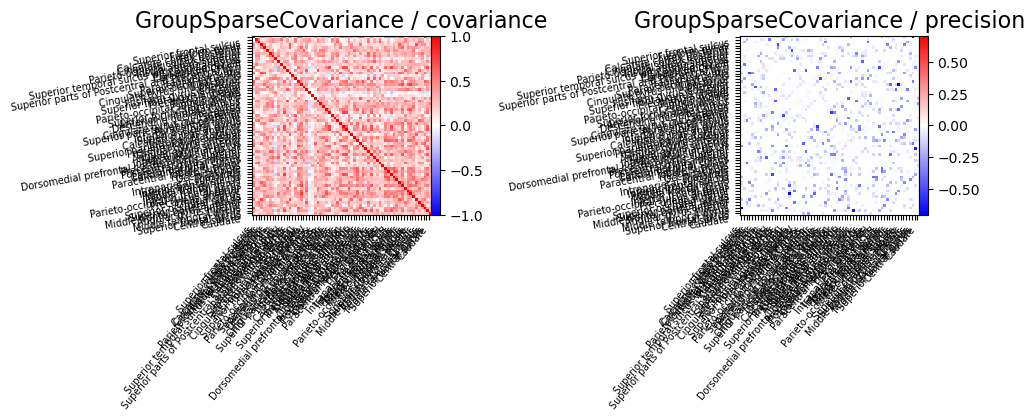

In [14]:
title = "GroupSparseCovariance"


def plot_matrices(cov, prec, title, labels):
    """Plot covariance and precision matrices, for a given processing."""
    prec = prec.copy()  # avoid side effects

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))

    # Display covariance matrix
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    plotting.plot_matrix(
        cov,
        cmap=plotting.cm.bwr,
        vmin=-1,
        vmax=1,
        title=f"{title} / covariance",
        labels=labels,
        axes=ax1
    )
    # Display precision matrix
    plotting.plot_matrix(
        prec,
        cmap=plotting.cm.bwr,
        vmin=-span,
        vmax=span,
        title=f"{title} / precision",
        labels=labels,
        axes=ax2
    )

    return fig

plotting.plot_connectome(
    -gsc.precisions_.mean(axis=2),
    atlas.get_coords(),
    edge_threshold="90%",
    title=title,
    display_mode="lzr",
)
# Mean ou pas mean?
plot_matrices(gsc.covariances_.mean(axis=2), gsc.precisions_.mean(axis=2), title, atlas.labels)

plotting.show()